# Information criteria - LOO & WAIC

## Create some data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Default seaborn theme, scaling & color palette

In [4]:
real_alpha = 4.25 
real_beta = [8.7, -1.2] 
data_size = 20

noise = np.random.normal(0, 2, size=data_size) 
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)]) 
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()

Text(0, 0.5, '$y$')

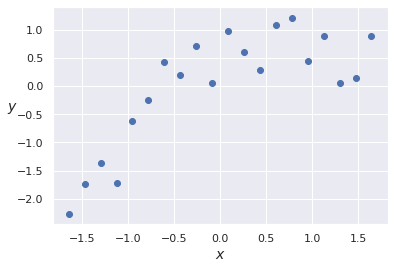

In [5]:
plt.scatter(x_1s[0], y_1s) 
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)

## Fit models

In [7]:
import pymc3 as pm

### Linear

In [8]:
model_1 = pm.Model()
with model_1:
    # priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)  # sd of gaussian noise
    
    mu = alpha + beta * x_1s[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1s)

In [9]:
with model_1:
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 3630.18draws/s]


/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a30054f10>,
      dtype=object)

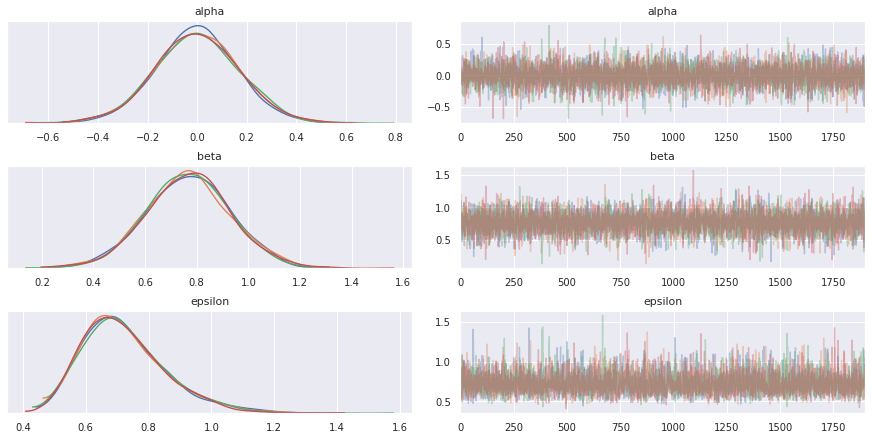

In [10]:
chain_1 = trace_1[100:]
varnames = ['alpha', 'beta', 'epsilon'] 
pm.traceplot(chain_1)

### Order-2 poly

In [12]:
x_1s.shape

(2, 20)

In [13]:
model_p = pm.Model()
with model_p:
    # priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=x_1s.shape[0])  # Two beta coefficients for 1st order poly
    epsilon = pm.HalfCauchy('epsilon', 5)  # gausssian noise
    
    mu = alpha + pm.math.dot(beta, x_1s)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1s)

In [14]:
with model_p:
    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1577.39draws/s]
The acceptance probability does not match the target. It is 0.7211055442686548, but should be close to 0.8. Try to increase the number of tuning steps.


/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a2cec03d0>,
      dtype=object)

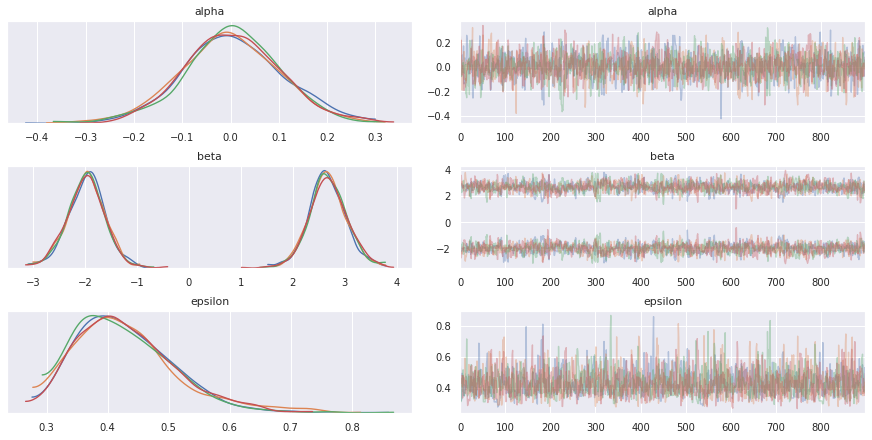

In [15]:
chain_p = trace_p[100:]
varnames = ['alpha', 'beta', 'epsilon'] 
pm.traceplot(chain_p)

## Plot the resulting best fits

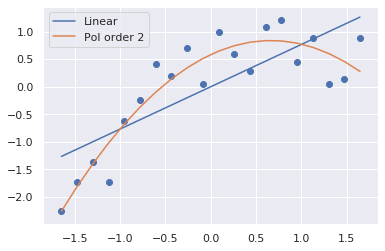

In [33]:
# linear
alpha_1_post = chain_1['alpha'].mean() 
betas_1_post = chain_1['beta'].mean(axis=0) 

idx = np.argsort(x_1s[0])
y_1_post = alpha_1_post + betas_1_post * x_1s[0] 
plt.plot(x_1s[0][idx], y_1_post[idx], label='Linear') 

# quadratic
alpha_p_post = chain_p['alpha'].mean() 
betas_p_post = chain_p['beta'].mean(axis=0) 

y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s) 
plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

# data
plt.scatter(x_1s[0], y_1s) 
plt.legend()

## Parms for model comparison
Think DIC has been removed in latest pymc3 version

### LOO

In [38]:
print('Linear:\n', pm.stats.loo(data=chain_1))
print('\nQuadratic:\n', pm.stats.loo(data=chain_p))

Linear:
 Computed from 7600 by 20 log-likelihood matrix

       Estimate       SE
IC_loo    45.03     3.98
p_loo      2.43        -

Quadratic:
 Computed from 3600 by 20 log-likelihood matrix

       Estimate       SE
IC_loo    25.44     4.86
p_loo      3.39        -


### WAIC

In [39]:
print('Linear:\n', pm.stats.waic(data=chain_1))
print('\nQuadratic:\n', pm.stats.waic(data=chain_p))

/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Linear:
 Computed from 7600 by 20 log-likelihood matrix

        Estimate       SE
IC_waic    44.91     3.94
p_waic      2.37        -

There has been a warning during the calculation. Please check the results.

Quadratic:
 Computed from 3600 by 20 log-likelihood matrix

        Estimate       SE
IC_waic    25.12     4.72
p_waic      3.23        -

There has been a warning during the calculation. Please check the results.
